# RAG

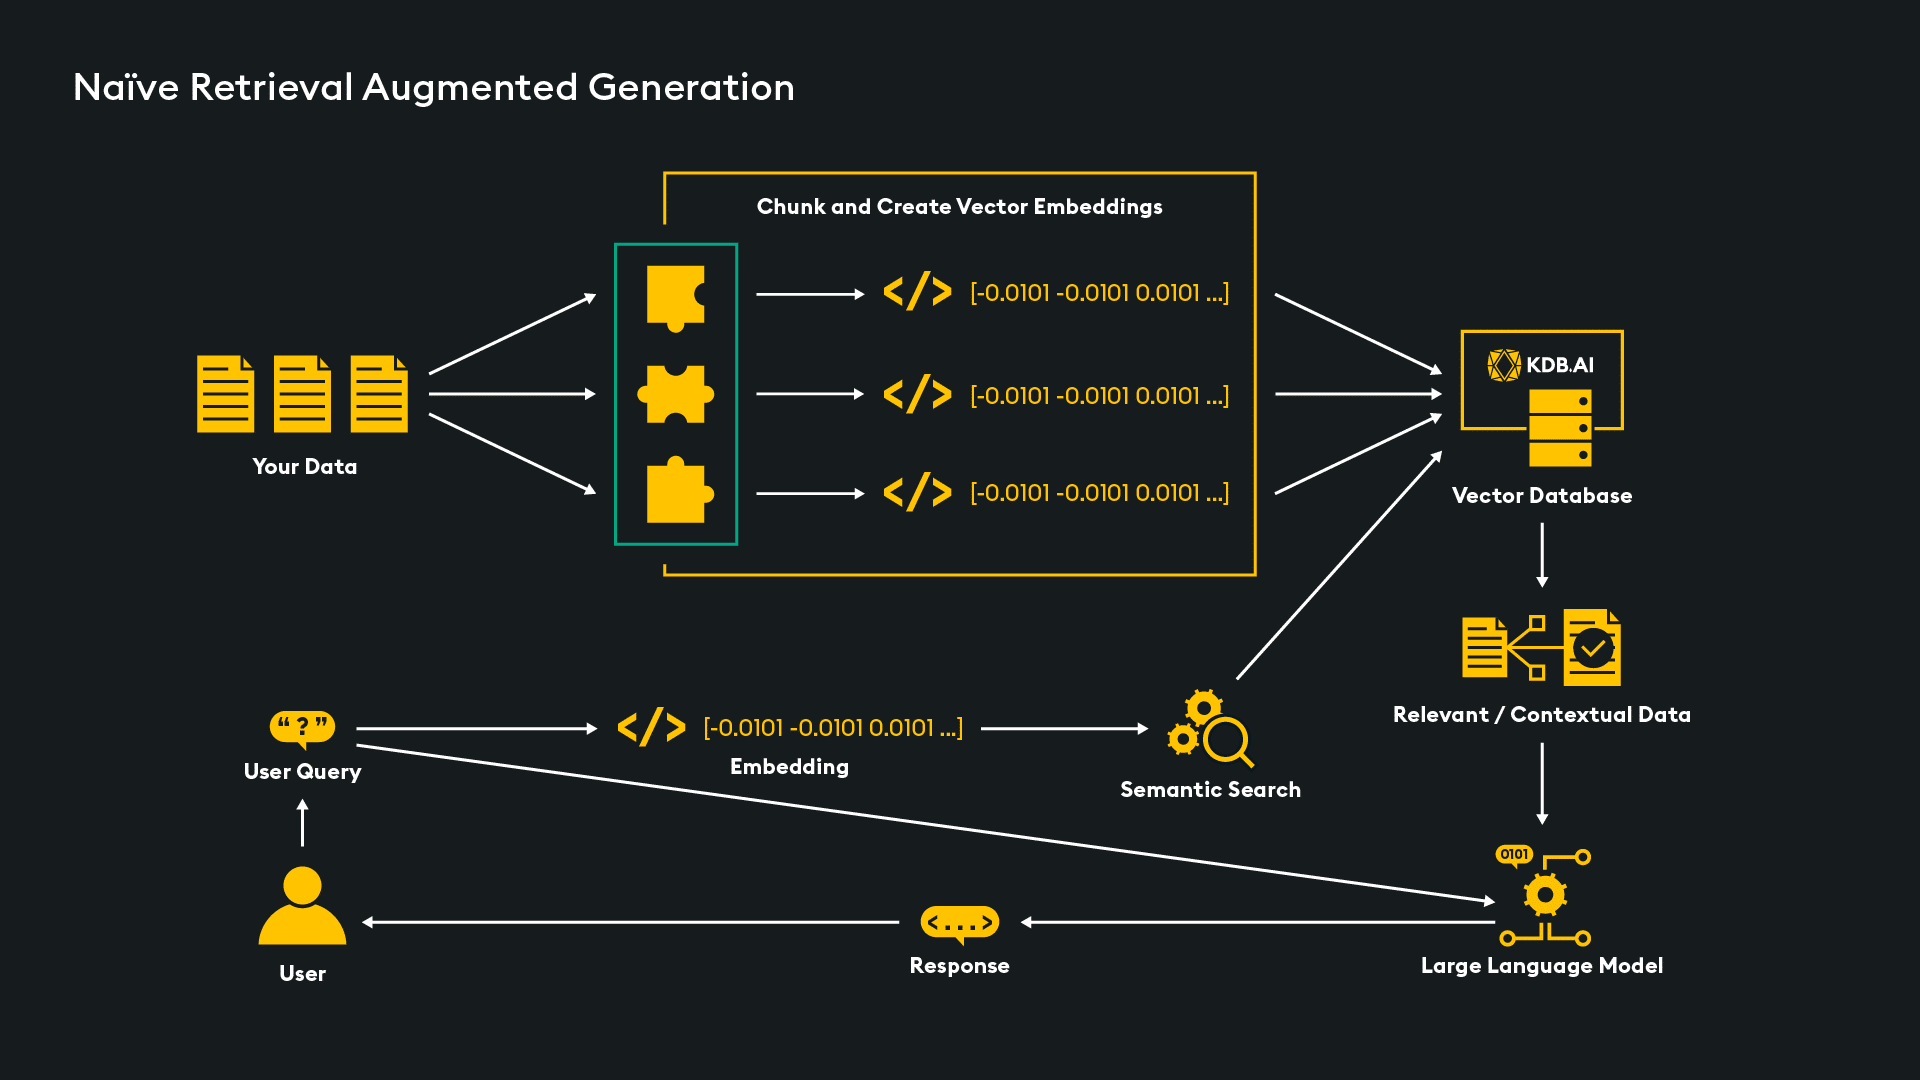

### On Our Infrastructure

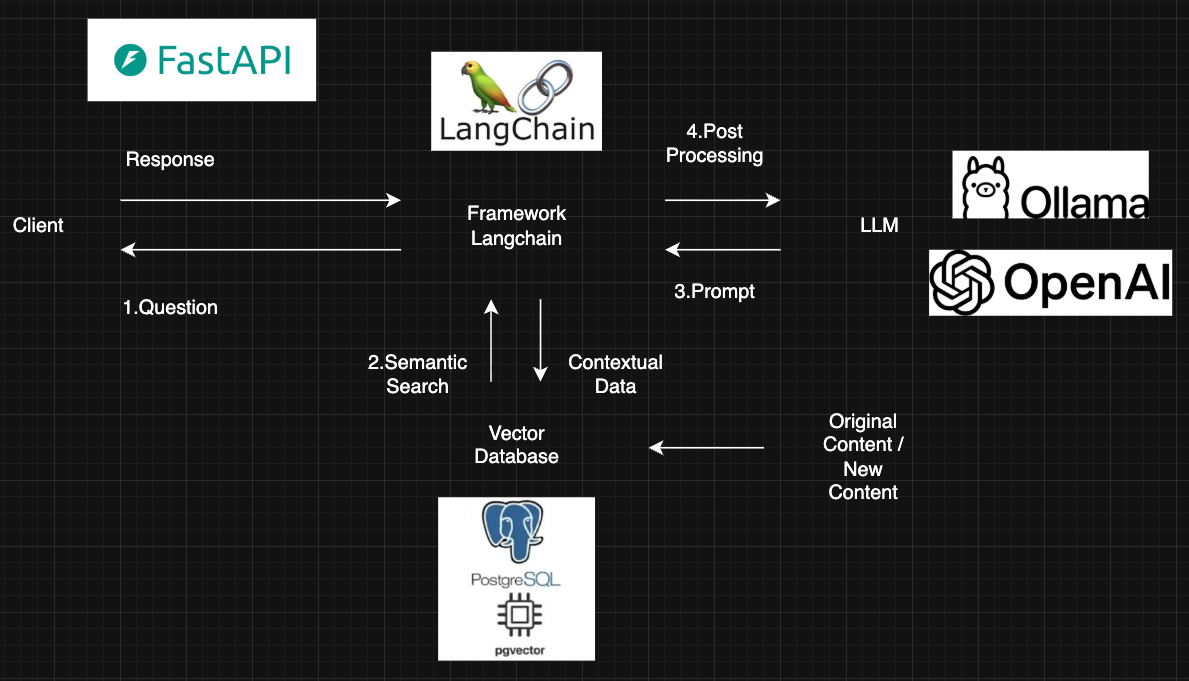

### Overview
One of the most powerful applications enabled by LLMs is sophisticated question-answering chatbots. These applications can answer questions about specific source information. They use a technique called Retrieval-Augmented Generation (RAG).

This tutorial will show you how to create a simple question-answering application from unstructured text data sources. We will demonstrate:
- A RAG agent that performs searches using a simple tool. This is a good general-purpose implementation.
- A two-step RAG chain that uses only a single LLM call per query. This is a fast and efficient method for simple queries.

### Concepts
We will cover the following concepts:
- Indexing: The process of ingesting data from a source and indexing it. This operation is typically performed in a separate process.
- Retrieval and Generation: The RAG process itself, which takes the user's query at runtime and retrieves relevant data from the index, then passes it to the model.

Once our data is indexed, we will use an agent as an orchestration framework to implement the retrieval and generation steps.

## 1. Installation and Configuration of Components

### Create Python Virtual Environment and Activate It

In [1]:
# Create and activate Python virtual environment
# This creates an isolated Python environment to avoid conflicts with system packages
# and ensures reproducible dependencies for the RAG project
# The virtual environment will contain all project-specific packages
# !python3 -m venv env
# !source env/bin/activate

### Install Required Libraries for the Project

In [2]:
# Install required libraries for the RAG project
# langchain: Core framework for building LLM applications and chains
# langchain-text-splitters: Utilities for splitting text into manageable chunks
# langchain-community: Community-contributed integrations and tools
# pydantic: Data validation and settings management using Python type hints
# python-dotenv: Load environment variables from .env files for secure configuration
# !pip install langchain langchain-text-splitters langchain-community pydantic python-dotenv

In [15]:
# Grouped and organized imports by category for better code organization and maintainability

# Standard library imports - built-in Python modules
import os  # Operating system interfaces for file paths, environment variables, and system operations
import logging  # Logging facility for tracking application behavior, debugging, and monitoring

# Third-party imports for configuration management and data validation
from dotenv import load_dotenv  # Securely load environment variables from .env files to keep sensitive data out of code
from pydantic_settings import BaseSettings  # Base class for settings management with automatic validation
from pydantic import Field, ValidationError  # Field definitions with validation rules and error handling classes

from langchain_community.document_loaders import PyPDFLoader  # PDF file loading and parsing utilities for document ingestion
from langchain_text_splitters import RecursiveCharacterTextSplitter  # Advanced text splitting strategies for managing large documents
from langchain_core.tools import tool  # Tool decorator for creating LangChain tools
from langchain.agents import create_agent  # Function to create LangChain agents

# Configure logging for the notebook environment
# Set logging level to INFO to capture important events without excessive verbosity
# Format includes timestamp, log level, and message for clear debugging and monitoring output
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

# Load environment variables from .env file if it exists
# This allows sensitive configuration like API keys to be stored securely outside the codebase
# Following security best practices by separating configuration from code
load_dotenv()

True

### Centralized Configuration Validation with Pydantic

In [ ]:
class RAGConfig(BaseSettings):
    """
    Validated configuration class for the RAG system.

    This Pydantic model defines all configuration parameters with validation,
    default values, and descriptions. It automatically loads values from
    environment variables and validates them at runtime.

    Attributes:
        openai_api_key: OpenAI API key for accessing GPT models and embeddings
        connection_string_pgvector: PostgreSQL connection string for PGVector database
        chat_model: OpenAI chat model for conversational responses
        embedding_model: OpenAI embedding model for vectorizing text
        collection_name: Name of the vector collection in PGVector
    """
    # Required API key for OpenAI services - no default to ensure security
    openai_api_key: str = Field(..., description="OpenAI API key for GPT models and embeddings")

    # Database connection string for vector storage
    connection_string_pgvector: str = Field(..., description="PostgreSQL connection string with PGVector extension")

    # Model configuration with sensible defaults
    chat_model: str = Field(default="gpt-5", description="OpenAI chat model for generating responses")
    embedding_model: str = Field(default="text-embedding-3-large", description="OpenAI embedding model for text vectorization")
    collection_name: str = Field(default="my_docs", description="Vector collection name in PGVector database")

    class Config:
        # Configuration for Pydantic settings
        env_file = ".env"  # Path to environment file
        env_prefix = ""    # No prefix for environment variables
        case_sensitive = False  # Case-insensitive environment variable matching

    def __repr__(self):
        # Custom string representation that masks sensitive information in logs
        # Only shows non-sensitive configuration details for security
        return f"RAGConfig(chat_model={self.chat_model}, embedding_model={self.embedding_model}, collection={self.collection_name})"

# Load and validate configuration from environment
try:
    config = RAGConfig()
    logger.info(f"Configuration loaded successfully: {config}")
    # Set the API key in environment for libraries that read it automatically
    os.environ["OPENAI_API_KEY"] = config.openai_api_key
except ValidationError as e:
    logger.error("Invalid configuration. Please check your .env file")
    for error in e.errors():
        logger.error(f"  - {error['loc'][0]}: {error['msg']}")
    raise SystemExit("Configuration error. Program terminated.")

### RAG Components Initialization (with Robust Error Handling)

In [5]:
def init_rag_components(config: RAGConfig):
    """
    Initialize RAG system components with robust error handling.

    This function sets up all necessary components for the RAG pipeline:
    - Chat model for generating responses
    - Embedding model for text vectorization
    - Vector store for document storage and retrieval

    Uses lazy imports to speed up initial loading and provides detailed
    error messages for troubleshooting.

    Args:
        config: Validated RAG configuration object

    Returns:
        tuple: (chat_model, embeddings, vector_store) - initialized components

    Raises:
        ImportError: If required libraries are not installed
        Exception: For other initialization failures (API keys, connections, etc.)
    """
    try:
        # Lazy imports to accelerate startup time
        # Only import heavy libraries when actually needed
        from langchain.chat_models import init_chat_model
        from langchain_openai import OpenAIEmbeddings
        from langchain_postgres import PGVector

        # Initialize chat model for conversational AI responses
        logger.info(f"Initializing chat model: {config.chat_model}")
        model = init_chat_model(config.chat_model)

        # Initialize embeddings for converting text to vector representations
        logger.info(f"Initializing embeddings: {config.embedding_model}")
        embeddings = OpenAIEmbeddings(model=config.embedding_model)

        # Initialize vector store with PGVector for persistent storage
        logger.info(f"Connecting to PGVector (collection: {config.collection_name})")
        vector_store = PGVector(
            embeddings=embeddings,
            collection_name=config.collection_name,
            connection=config.connection_string_pgvector,
        )

        logger.info("✓ All components initialized successfully")
        return model, embeddings, vector_store

    except ImportError as e:
        logger.error(f"Import error: {e}")
        logger.error("Ensure all dependencies are installed (langchain, langchain-openai, langchain-postgres)")
        raise
    except Exception as e:
        logger.error(f"Error during initialization: {e}")
        raise

# Initialize RAG components with error handling
model, embeddings, vector_store = init_rag_components(config)

INFO: Initializing chat model: gpt-5-mini
INFO: Initializing embeddings: text-embedding-3-large
INFO: Connecting to PGVector (collection: my_docs)
INFO: Initializing embeddings: text-embedding-3-large
INFO: Connecting to PGVector (collection: my_docs)
INFO: ✓ All components initialized successfully
INFO: ✓ All components initialized successfully


### Quick System Verification

In [6]:
# Quick test to verify everything is working correctly
try:
    # Test the chat model with a simple greeting
    logger.info("Testing chat model...")
    test_response = model.invoke("Hello")
    logger.info(f"✓ Model operational (response: {test_response.content[:100]}...)")

    # Display information about the vector store connection
    logger.info(f"✓ Vector store connected: {config.collection_name}")

except Exception as e:
    logger.warning(f"Warning during tests: {e}")
    logger.warning("Components are initialized but may require verification")

# Display system status summary
print("\n" + "="*60)
print("🚀 RAG System Ready for Use!")
print("="*60)
print(f"Model: {config.chat_model}")
print(f"Embeddings: {config.embedding_model}")
print(f"Collection: {config.collection_name}")
print("="*60)

INFO: Testing chat model...
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: ✓ Model operational (response: Hello! How can I help you today?...)
INFO: ✓ Vector store connected: my_docs
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: ✓ Model operational (response: Hello! How can I help you today?...)
INFO: ✓ Vector store connected: my_docs



🚀 RAG System Ready for Use!
Model: gpt-5-mini
Embeddings: text-embedding-3-large
Collection: my_docs


## 2. Indexing

This section is an abbreviated version of the content from the semantic search tutorial.
If your data is already indexed and available for search (i.e., you have a function to perform search), or if you are comfortable with document loaders, embeddings, and vector stores, feel free to skip to the next section on retrieval and generation.

Indexing typically works as follows:
- Loading: We first need to load our data. This is done using document loaders.
- Splitting: Text splitters divide large Documents into smaller chunks. This is useful both for indexing data and fitting them into a model, as large chunks are harder to search through and don't fit in a model's limited context window.
- Storage: We need a place to store and index our splits so we can search them later. A VectorStore and Embeddings model is often used for this.

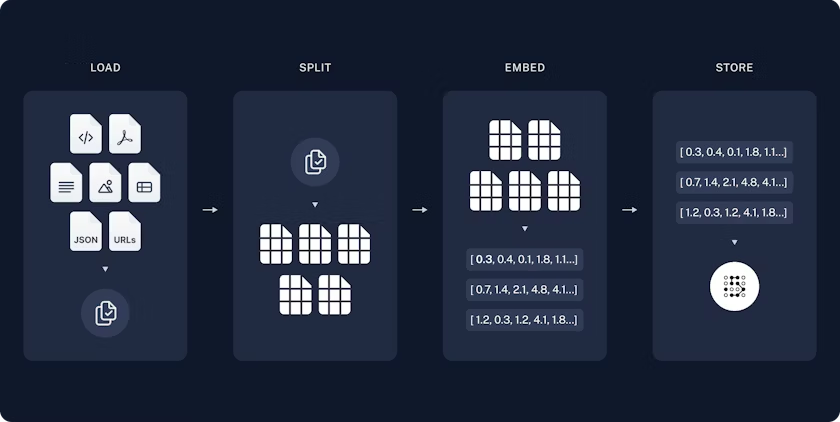

### PDF Documents Import

DocumentLoader: Object that loads data from a source as a list of Documents.
- Integrations: Over 160 integrations to choose from.
- BaseLoader: API reference for the base interface.

In [7]:
# Load PDF document using PyPDFLoader from LangChain
# This loader extracts text content from PDF files and converts them to Document objects
# Each page becomes a separate Document with metadata including source file and page number
file_path = "/Users/leohoareau/Documents/projects/rag_chatbot/rag_langchain/data/plaquettes/plaquette_DALLES_ISOLANTES.pdf"
loader = PyPDFLoader(file_path)
docs = loader.load()

# Display basic information about loaded documents
print(f"Documents loaded: {len(docs)}")
print("Sample metadata:", docs[0].metadata if docs else None)
print(f"Total characters: {len(docs[0].page_content)}")

Documents loaded: 2
Sample metadata: {'producer': 'Adobe PDF Library 17.0', 'creator': 'Adobe InDesign 19.1 (Macintosh)', 'creationdate': '2024-01-24T16:08:45+01:00', 'moddate': '2024-01-24T16:08:45+01:00', 'trapped': '/False', 'source': '/Users/leohoareau/Documents/projects/rag_chatbot/rag_langchain/data/plaquettes/plaquette_DALLES_ISOLANTES.pdf', 'total_pages': 2, 'page': 0, 'page_label': '1'}
Total characters: 311


### Content Display

In [8]:
# Display the first 5000 characters of the first document
# This shows the actual text content extracted from the PDF
# Useful for verifying the quality of text extraction and content structure
print(docs[0].page_content[:5000])

Courants d’air froid, facture énergétique élevée, 
humidité, ponts thermiques, jusqu’à 30% de déperdi-
tion d’énergie(1)
PROBLÈMES : 
Vos combles isolés restent accessibles !
SOLUTION :
APRÈS
AVANT
Revalorisation 
du patrimoine
Efficace sur le 
long terme
Contrat 
transparence
Dalles isolantes
Pour les combles


In [9]:
# Display the first 5000 characters of the second document
# Shows content from the second page of the PDF
print(docs[1].page_content[:5000])

SAS Technitoit «La maison auto-nettoyante», 5 rue Gutenberg - 49130 Les Ponts de Cé - Tél.: 02.41.72.67.20 - Fax: 02.41.72.67.21 - Siret 443 484 050 00044 - Code APE 7010 Z. Visuels non-contractuels. Attention nous 
vous informons qu’il peut y avoir des variations minimes entre la photographie et le produit ou la prestation de service.  Édité en janvier 2024.
TECHNITOIT, UNIQUE FABRICANT-APPLICATEUR, LEADER FRANÇAIS DE LA RÉNOVATION DE L ’HABITAT DEPUIS 2002
Dalles isolantes
Quand on isole ses combles perdus, ils deviennent souvent difficiles 
d’accès, et l’espace de stockage possible est souvent perdu. Les dalles 
isolantes permettent de résoudre ce problème, tout en offrant un gain 
d’isolation !
CARACTÉRISTIQUES ET AVANTAGES
• Permet d’isoler et de créer une surface de stockage dans les combles perdus ayant 
un plancher béton ou bois, ou sans plancher en fixant les dalles directement sur les 
solives
• Supprime les ponts thermiques
• Excellente performance thermique et acoustique
• 

### Document Splitting

Our document contains more than X thousand characters, which is too long to fit in many models' context windows. Even for models capable of displaying the entire text in their context window, searching for information in very long texts can be difficult.

To address this, we will split the text Document into segments for embedding and vector storage. This should allow us to retrieve only the most relevant parts of the article when needed.

As in the semantic search tutorial, we use a RecursiveCharacterTextSplitter that recursively segments the document using common separators such as line breaks, until each segment has the appropriate size. This is the recommended text splitter for general use cases.

TextSplitter: Object that splits a list of Document objects into smaller chunks for storage and retrieval.
- Integrations
- Interface: API reference for the base interface.

In [10]:
# Create a RecursiveCharacterTextSplitter for document chunking
# This splitter recursively divides text using common separators (newlines, spaces, etc.)
# until each chunk reaches the desired size with some overlap for context preservation

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # Maximum characters per chunk for optimal retrieval
    chunk_overlap=200,  # Overlap between chunks to maintain context continuity
    add_start_index=True,  # Include character position tracking in metadata
)
all_splits = text_splitter.split_documents(docs)

# Display the result of document splitting
print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 5 sub-documents.


### Storing Documents as Vectors Using OpenAI Embeddings in PGVector Database

We now need to index our 66 text segments so we can perform searches at runtime. Following the semantic search tutorial, our approach is to embed the content of each document segment and insert these vector representations into a vector space. From a query, we can then use vector search to retrieve relevant documents.

We can embed and store all our document splits in a single command using the selected vector store and embedding model.

In [11]:
# Add all document splits to the vector store
# This embeds each text chunk using the configured embedding model
# and stores the resulting vectors in the PGVector database for later retrieval
# Returns document IDs that can be used for tracking and management
document_ids = vector_store.add_documents(documents=all_splits)

# Display first 3 document IDs as a sample
print(document_ids[:3])

INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


['eb1d400c-14a8-4f32-85b5-848475bc3614', 'dee39895-c5b8-4dbe-a28d-1fcaf3de49e7', '381abd6b-8dbd-451a-a1a7-65c658a52465']


Embeddings: Wrapper around a text embedding model, used to convert text to vectors.
- Integrations: Over 30 integrations to choose from.
- Interface: API reference for the base interface.

VectorStore: Interface around a vector database, used to store and query vector representations.

- Integrations: Over 40 integrations to choose from.
- Interface: API reference for the base interface.

Indexing is now complete. We have a searchable vector store containing the excerpts from our article. Ideally, when faced with a user question, we should be able to return the passages from the article that answer it.

## 3. Retrieval and Generation

RAG applications typically work as follows:
- 1. Retrieval: From a user input, relevant splits are retrieved from storage using a retriever.
- 2. Generation: A model produces a response from a prompt that includes both the question and the retrieved data.

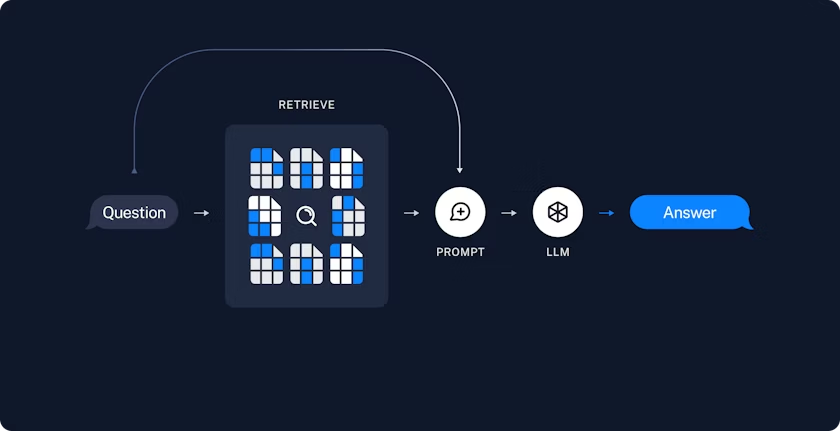

Now let's move to the actual application logic. We want to create a simple application that takes a user's question, searches for relevant documents, passes the found documents and the initial question to a model, then returns a response.

We will demonstrate:
- 1. A RAG agent that performs searches using a simple tool. This is a good general-purpose implementation.
- 2. A two-step RAG chain that uses only a single LLM call per query. This is a fast and efficient method for simple queries.

### Creating a Tool for Retrieving Content Related to the Query by Semantic Search in the Vector Database

In [12]:
# Create a retrieval tool using LangChain's tool decorator
# This tool encapsulates the vector database search functionality
# and can be used by AI agents to retrieve relevant context for queries
@tool(response_format="content_and_artifact")
def retrieve_context(query: str):
    """
    Retrieve information to help answer a query.

    This tool performs semantic search in the vector database to find
    documents most relevant to the user's query. It returns both
    formatted content and raw document artifacts for further processing.

    Args:
        query: The search query string

    Returns:
        tuple: (serialized_content, raw_documents) - formatted text and document objects
    """
    # Perform similarity search to find relevant documents
    retrieved_docs = vector_store.similarity_search(query, k=2)

    # Serialize documents into readable format for the LLM
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

We use the tool decorator here to configure it to attach raw documents as artifacts to each ToolMessage. This will allow us to access the documents' metadata in our application, independently of their string representation sent to the model.

Search tools are not limited to a single string query argument, as in the example above. You can force the LLM to specify additional search parameters, for example a category:

In [13]:
# Example of a more complex retrieval tool with additional parameters
# This shows how to add more search criteria beyond just the query string
# The LLM would be forced to specify both query and section parameters
# from typing import Literal

# def retrieve_context(query: str, section: Literal["beginning", "middle", "end"]):
#     # Implementation would filter results based on document section
#     pass

### Creating an AI Agent for Discussion Using the Retrieval Tool Created Above

Agentic Approach (RAG-Agent)

An agent decides dynamically whether to search or not, then produces a response.

Usage when the need for retrieval depends on the question or context (e.g., multi-turn chatbot that evaluates whether to consult documents).

Advantages: more flexible, avoids unnecessary searches. Disadvantage: more complex, may require multiple LLM calls.

In [16]:
# Create an agent using the retrieval tool
# The agent will have access to the retrieve_context tool and can decide when to use it
# Custom instructions guide the agent on how to use the tool effectively
tools = [retrieve_context]

# Define custom instructions for the agent
prompt = (
    "You have access to a tool that retrieves context from a blog post. "
    "Use the tool to help answer user queries."
)

# Create the agent with the specified tools and system prompt
agent = create_agent(model, tools, system_prompt=prompt)

## Testing the Agent

Now let's test our agent with a query that requires context retrieval from the blog posts.

In [17]:
# Test the agent with a query about Technitoit innovative slabs
# This query requires retrieving context from the blog posts to provide accurate information
# The agent will use the retrieve_context tool to find relevant information
query = (
    "What are the technical characteristics of Technitoit's innovative slabs?"
)

# Stream the agent's response to see the reasoning process
# The agent will first use the tool to retrieve context, then generate a response
for event in agent.stream(
    {"messages": [{"role": "user", "content": query}]},
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What are the technical characteristics of Technitoit's innovative slabs?


INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================
Tool Calls:
  retrieve_context (call_jTQp0QR6R3pbHFYjnoKtZZCf)
 Call ID: call_jTQp0QR6R3pbHFYjnoKtZZCf
  Args:
    query: Technitoit innovative slabs technical characteristics slabs 'Technitoit' 'innovative slabs' technical characteristics blog post


INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


================================= Tool Message =================================
Name: retrieve_context

Source: {'page': 1, 'source': '/Users/leohoareau/Documents/projects/rag_chatbot/rag_langchain/data/plaquettes/plaquette_DALLES_ISOLANTES.pdf', 'creator': 'Adobe InDesign 19.1 (Macintosh)', 'moddate': '2024-01-24T16:08:45+01:00', 'trapped': '/False', 'producer': 'Adobe PDF Library 17.0', 'page_label': '2', 'start_index': 0, 'total_pages': 2, 'creationdate': '2024-01-24T16:08:45+01:00'}
Content: SAS Technitoit «La maison auto-nettoyante», 5 rue Gutenberg - 49130 Les Ponts de Cé - Tél.: 02.41.72.67.20 - Fax: 02.41.72.67.21 - Siret 443 484 050 00044 - Code APE 7010 Z. Visuels non-contractuels. Attention nous 
vous informons qu’il peut y avoir des variations minimes entre la photographie et le produit ou la prestation de service.  Édité en janvier 2024.
TECHNITOIT, UNIQUE FABRICANT-APPLICATEUR, LEADER FRANÇAIS DE LA RÉNOVATION DE L ’HABITAT DEPUIS 2002
Dalles isolantes
Quand on isole ses

INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================
Tool Calls:
  retrieve_context (call_6ENkQdG1irkg6QbEsCIXRPqC)
 Call ID: call_6ENkQdG1irkg6QbEsCIXRPqC
  Args:
    query: Dalles isolantes Technitoit caractéristiques techniques dimensions épaisseur matériau résistance charge 'dalles innovantes' 'Technitoit' 'caractéristiques techniques' 'plaquette'


INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


================================= Tool Message =================================
Name: retrieve_context

Source: {'page': 1, 'source': '/Users/leohoareau/Documents/projects/rag_chatbot/rag_langchain/data/plaquettes/plaquette_DALLES_ISOLANTES.pdf', 'creator': 'Adobe InDesign 19.1 (Macintosh)', 'moddate': '2024-01-24T16:08:45+01:00', 'trapped': '/False', 'producer': 'Adobe PDF Library 17.0', 'page_label': '2', 'start_index': 0, 'total_pages': 2, 'creationdate': '2024-01-24T16:08:45+01:00'}
Content: SAS Technitoit «La maison auto-nettoyante», 5 rue Gutenberg - 49130 Les Ponts de Cé - Tél.: 02.41.72.67.20 - Fax: 02.41.72.67.21 - Siret 443 484 050 00044 - Code APE 7010 Z. Visuels non-contractuels. Attention nous 
vous informons qu’il peut y avoir des variations minimes entre la photographie et le produit ou la prestation de service.  Édité en janvier 2024.
TECHNITOIT, UNIQUE FABRICANT-APPLICATEUR, LEADER FRANÇAIS DE LA RÉNOVATION DE L ’HABITAT DEPUIS 2002
Dalles isolantes
Quand on isole ses

INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================
Tool Calls:
  retrieve_context (call_OzDznIm0HMlcIFYnAzLUu9g4)
 Call ID: call_OzDznIm0HMlcIFYnAzLUu9g4
  Args:
    query: Technitoit dalles isolantes épaisseur dimensions 'technitoit dalles' 'caractéristiques' 'charge' 'thermique' 'acoustique' 'R' 'lambda' 'résistance thermique'


INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


================================= Tool Message =================================
Name: retrieve_context

Source: {'page': 1, 'source': '/Users/leohoareau/Documents/projects/rag_chatbot/rag_langchain/data/plaquettes/plaquette_DALLES_ISOLANTES.pdf', 'creator': 'Adobe InDesign 19.1 (Macintosh)', 'moddate': '2024-01-24T16:08:45+01:00', 'trapped': '/False', 'producer': 'Adobe PDF Library 17.0', 'page_label': '2', 'start_index': 2529, 'total_pages': 2, 'creationdate': '2024-01-24T16:08:45+01:00'}
Content: accessible et sécurisée, donnant accès au réseau technique sous toiture.
Caractéristiques techniques
R (m²-k/W) : 7,1
CARACTÉRISTIQUES DES DALLES ISOLANTES
Dimensions 1495 mm x 560 mm
Épaisseur 240 mm (PSE) + 8 mm (OSB)
Conductivité thermique de l’isolant PSE 34 mW/(m.K)
Conductivité thermique de l’OSB 130 mW/(m.K)
Euroclasse feu PSE E
Euroclasse feu OSB D-s2, d0
Perméabilité à la vapeur d’eau μ OSB 150 - 200

Source: {'page': 1, 'source': '/Users/leohoareau/Documents/projects/rag_chatbot/r

INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Here are the technical characteristics of Technitoit’s insulating slabs:

- Thermal resistance (R): 7.1 m²·K/W  
- Panel dimensions: 1495 × 560 mm  
- Thickness: 240 mm (PSE insulation) + 8 mm OSB facing  
- Thermal conductivity:
  - PSE: 34 mW/(m·K) = 0.034 W/(m·K)
  - OSB: 130 mW/(m·K) = 0.130 W/(m·K)
- Fire classification:
  - PSE: Euroclass E
  - OSB: Euroclass D‑s2, d0
- Water vapour permeability (OSB): μ = 150–200

Additional functional benefits noted:
- Allows insulation while creating a safe storage surface in lost attics (on concrete or timber floors, or fixed directly to joists)
- Eliminates thermal bridges
- Provides excellent thermal and acoustic performance

If you want, I can convert these specs into recommended installation notes, load-bearing capacity questions, or compare them to other common attic insulation solutions.


Note that the agent:
- 1. Generates a query to search for a standard task decomposition method;
- 2. Upon receiving the response, generates a second query to search for its common extensions;
- 3. Having received all necessary context, it answers the question.

## RAG Chains

In the agentic RAG formulation above, we let the LLM use its discretionary power to generate a tool call to respond to user queries. This is a good general-purpose solution, but it has some disadvantages:

![Screenshot 2025-11-03 at 14.30.45.png](<attachment:Screenshot 2025-11-03 at 14.30.45.png>)

### Alternative Approach

Classic RAG Chain (two-step)

We always retrieve documents then make a single call to the LLM with the retrieved context.

Usage when we know we need to search in a corpus every time (ex: Q&A on internal data).

Advantages: simple, fast. Disadvantage: always expensive in retrieval even if the answer could be in the LLM alone.

The other common approach consists of a two-step chain: we systematically perform a search (potentially from the raw user query) and integrate the result as context for a single LLM query. This results in a single inference call per query, reducing latency at the expense of flexibility.

In this approach, we no longer call the model in a loop, but perform a single pass.

We can implement this chain by removing the tools from the agent and instead integrating the retrieval step into a custom prompt:

In [18]:
# Import middleware for dynamic prompt injection and agent creation
from langchain.agents.middleware import dynamic_prompt, ModelRequest
from langchain.agents import create_agent

# Define a dynamic prompt function that injects retrieved context
# This middleware runs before each model call to add relevant documents to the system message
@dynamic_prompt
def prompt_with_context(request: ModelRequest) -> str:
    """Inject context into state messages by retrieving relevant documents."""
    # Extract the last user query from the conversation
    last_query = request.state["messages"][-1].text

    # Perform similarity search to find relevant documents
    retrieved_docs = vector_store.similarity_search(last_query)

    # Combine all retrieved document contents with double newlines as separators
    docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)

    # Create system message with retrieved context
    system_message = (
        "You are a helpful assistant. Use the following context in your response:"
        f"\n\n{docs_content}"
    )

    return system_message

# Create agent without tools but with context injection middleware
# This implements a two-step RAG: retrieve context, then generate response in one pass
agent = create_agent(model, tools=[], middleware=[prompt_with_context])

In [19]:
# Test the two-step RAG chain with the same query
# This approach performs retrieval once and includes context in a single LLM call
query = "What are the technical characteristics of Technitoit's innovative slabs?"

# Stream the response - should be faster than agentic approach since only one LLM call
for step in agent.stream(
    {"messages": [{"role": "user", "content": query}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What are the technical characteristics of Technitoit's innovative slabs?


INFO: HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

Technitoit’s insulating slabs — key technical characteristics

- Designed for combles perdus (unused/attic spaces) — allow insulation while creating a usable storage surface.  
- Can be installed on a concrete or wood floor, or fixed directly onto joists when there is no existing floor.  
- Eliminates thermal bridges.  
- Excellent thermal performance (improved insulation) and acoustic performance (noise reduction).  
- Fully recyclable.  

Additional practical notes: installation benefits from a décennale (10‑year) warranty on the pose; eligibility for certain energy‑transition grants and applicable VAT rates depend on specific conditions.


### Next Steps

Now that we have implemented a simple RAG application via create_agent or two-step RAG chain, we can easily integrate new features and go further:
- [Stream](https://docs.langchain.com/oss/python/langchain/rag#:~:text=and%20go%20deeper%3A-,Stream,-tokens%20and%20other) tokens and other information for reactive user experiences
- Add [conversational memory](https://docs.langchain.com/oss/python/langchain/rag#:~:text=conversational%20memory) to support multi-turn interactions
- Add [long-term memory](https://docs.langchain.com/oss/python/langchain/rag#:~:text=Add-,long%2Dterm%20memory,-to%20support%20memory) to manage memory between conversation threads
- Add [structured responses](https://docs.langchain.com/oss/python/langchain/rag#:~:text=structured%20responses)
- Deploy your application with [LangSmith Deployments](https://docs.langchain.com/oss/python/langchain/rag#:~:text=LangSmith%20Deployments)